# Robert Chatterton

#### DS 4400 Machine Learning and Data Mining I Final Project

<hr />

## Authorship Attribution on Classical Works and More

In [1]:
# math and data
import numpy as np
import random
import collections
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context('paper')

# natural language processing
import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('gutenberg')
nltk.download('punkt')

# first 3 models - SVC, Random Forest, and Naive Bayes
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelBinarizer, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# CNN
from keras.callbacks import Callback
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.metrics import Precision, Recall
from keras.preprocessing.text import one_hot
from keras.utils.vis_utils import plot_model

[nltk_data] Downloading package stopwords to /home/robbie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/robbie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/robbie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package gutenberg to /home/robbie/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/robbie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Cleaning

In [2]:
minimum_sentence_length = 1

def create_sentence_list(work):
    raw = nltk.corpus.gutenberg.raw(work)
    
    # fix up text
    text = raw.replace('."', '".').replace('?"', '"?').replace('!"', '"!')
    text = text.replace('--', ' ').replace('. . .', '').replace('_', '')
    text = text.replace('\n', ' ').replace('  ', ' ').replace('  ', ' ')

    # tokenize into sentences
    sents = nltk.tokenize.sent_tokenize(text)

    # remove short sentences
    sents = [sent for sent in sents if len(sent) >= minimum_sentence_length]
    print(f'{work} has {len(sents)} sentences')
    return sents

# authors and works to investigate
austen = create_sentence_list('austen-persuasion.txt') + create_sentence_list('austen-sense.txt')
chesterton = create_sentence_list('chesterton-ball.txt') + create_sentence_list('chesterton-brown.txt') + create_sentence_list('chesterton-thursday.txt')
shakespeare = create_sentence_list('shakespeare-caesar.txt') + create_sentence_list('shakespeare-hamlet.txt') + create_sentence_list('shakespeare-macbeth.txt')

works = {
    'austen': austen, 
    'chesterton': chesterton, 
    'shakespeare': shakespeare
}

for a, w in works.items():
    print(f'{a} has {len(w)} sentences total')

austen-persuasion.txt has 3657 sentences
austen-sense.txt has 5195 sentences
chesterton-ball.txt has 4636 sentences
chesterton-brown.txt has 3727 sentences
chesterton-thursday.txt has 3570 sentences
shakespeare-caesar.txt has 1592 sentences
shakespeare-hamlet.txt has 2355 sentences
shakespeare-macbeth.txt has 1465 sentences
austen has 8852 sentences total
chesterton has 11933 sentences total
shakespeare has 5412 sentences total


In [3]:
# slightly lower than least amount of sentences of any author
to_choose = 5000
sentences = []
sentence_labels = []

for author, sents in works.items():
    chosen = np.random.choice(sents, to_choose, replace=False)
    sentences += list(chosen)
    sentence_labels += [author] * to_choose

# shuffle list randomly
Xy = list(zip(sentences, sentence_labels))
random.shuffle(Xy)
X, y = zip(*Xy)

df = pd.DataFrame()
df['sentence'] = X
df['author'] = y
df.head(10)

,sentence,author
0,"""The cross cannot be defeated,"" said MacIan, ""...",chesterton
1,"Though all things foule, would wear the brows ...",shakespeare
2,"""There now; you see how droll he is.",austen
3,"Flourish, and Shout.",shakespeare
4,We asked him to come home with us for a day or...,austen
5,Oh 'tis true: How smart a lash that speech dot...,shakespeare
6,Marianne was still handsomer.,austen
7,I take it that it's nobody's business but mine...,chesterton
8,"Yes,"" said the old man, nodding a great many t...",chesterton
9,"""O God!",chesterton


In [4]:
# each author has the same number of randomly selected sentences
len(np.where(df['author'] == 'chesterton')[0]), len(np.where(df['author'] == 'austen')[0]), len(np.where(df['author'] == 'shakespeare')[0])

(5000, 5000, 5000)

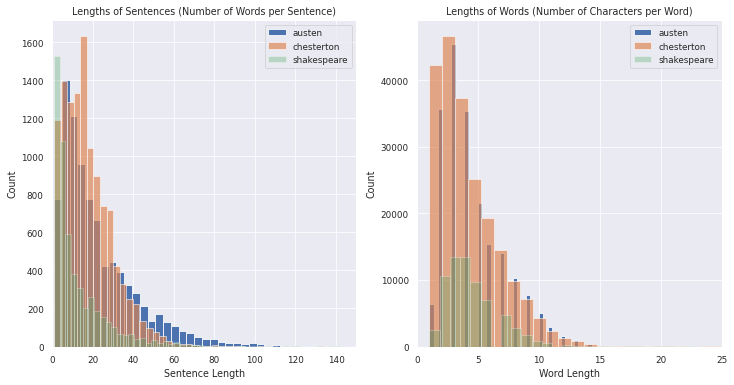

In [36]:
# sentence length, word length
def get_lengths(works):
    sent_lengths = []
    word_lengths = []
    for sent in works:
        split_ = sent.split()
        sent_lengths.append(len(split_))
        for word in split_:
            word_lengths.append(len(word))
    return np.array(sent_lengths), np.array(word_lengths)

fig, axs = plt.subplots(1, 2)
num_bins = 50
opacity = [1, 0.67, 0.33]

for i, item in enumerate(works.items()):
    author, sentences = item[0], item[1]
    sents, words = get_lengths(sentences)
    axs[0].hist(sents, bins=num_bins, label=author, alpha=opacity[i])
    axs[1].hist(words, bins=num_bins, label=author, alpha=opacity[i])

axs[0].set_title('Lengths of Sentences (Number of Words per Sentence)')
axs[1].set_title('Lengths of Words (Number of Characters per Word)')

axs[0].set_xlabel('Sentence Length')
axs[1].set_xlabel('Word Length')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')

axs[0].set_xlim(0, 150)
axs[1].set_xlim(0, 25)

axs[0].legend()
axs[1].legend()
fig.set_size_inches((12,6))

# save
plt.savefig('lengths.png', format='png')

# Prepare Data

In [6]:
def get_vocab_size(excerpt_list, n, seq_size):
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams           
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Create list of n-grams
        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    # Flatten n-gram list
    n_gram_list = list(np.array(n_gram_list).flat)
    
    # Calculate vocab size
    n_gram_cnt = collections.Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

def create_n_grams(excerpt_list, n, vocab_size, seq_size):
    n_gram_list = []

    for excerpt in excerpt_list:
        # remove spaces
        excerpt = excerpt.replace(" ", "")

        # extract n-grams
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # convert to a single string with spaces between n-grams
        new_string = " ".join(n_grams)

        # one hot encode
        hot = one_hot(new_string, round(vocab_size*1.3))

        # pad hot if necessary
        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [8]:
# vocab sizes necessary to know for creating 3 grams
train_vs = get_vocab_size(X_train, 3, 350)
test_vs = get_vocab_size(X_test, 3, 350)
print(train_vs, test_vs)

19410 13751


In [9]:
# create 3 grams
three_grams_train = create_n_grams(X_train, 3, train_vs, 350)
three_grams_test = create_n_grams(X_test, 3, test_vs, 350)
three_grams_train.shape, three_grams_test.shape, np.max(three_grams_train), three_grams_train[0]

((11250, 350),
 (3750, 350),
 25232,
 array([22289, 14416, 13234,  2070,  2400,  1377, 15256, 12405, 14917,
         1545,  4960, 18288,  7980,  2362,    36, 18219, 15250,  9808,
         9374,  8124, 11940, 20883,  1893, 12777,  1220,  2220,  7175,
        22082, 13856,  7637,  6319,   816,  8103,  9833, 20710,  6379,
        17846, 16182, 13833, 18420, 23175, 15256, 10255,  6907,  4487,
         3683, 10255, 18043,  4686, 24195, 15190, 23008, 22679,  7373,
         4228,  3592, 17766,  5180, 17408, 11985,  6425,  8606, 17258,
        11854, 23701,  3195, 18543,  9773, 23410, 23223, 11293,   574,
         1787,  5898, 11753, 12231,  5466, 18420,  9397,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     

In [10]:
def lemmatize_text(sentences):
    stop_words = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
    lemmatized = []
    
    for sentence in sentences:
        new = sentence.split()
        word_list = [lemma.lemmatize(w.lower(), pos='v') for w in new if not w in stop_words] # lemmatize verbs
        word_list = [lemma.lemmatize(w.lower(), pos='n') for w in new if not w in stop_words] # lemmatize nouns
        word_list = [lemma.lemmatize(w.lower(), pos='a') for w in new if not w in stop_words] # lemmatize adjectives
        word_list = [lemma.lemmatize(w.lower(), pos='r') for w in new if not w in stop_words] # lemmatize adverbs
        word_list = [lemma.lemmatize(w.lower(), pos='s') for w in new if not w in stop_words] # lemmatize satellite adjectives
        word_list = " ".join(word_list)
        lemmatized.append(word_list)
    
    return lemmatized

In [11]:
processed_train = lemmatize_text(X_train)
processed_test = lemmatize_text(X_test)

# sample of a lemmatized sentence
processed_train[150]

'"i small objection account," replied anne.'

In [12]:
# create features
vector = TfidfVectorizer(strip_accents='ascii', stop_words='english', min_df=7)
vector.fit(processed_train)

words_train = vector.transform(processed_train)
words_test = vector.transform(processed_test)

words_train[0]

In [13]:
# encode author labels
lb = LabelBinarizer()
lb.fit(y_train)
author_one_hot_train = lb.transform(y_train)
author_one_hot_test = lb.transform(y_test)

author_one_hot_train[0]

# Implement Models

## SVC

In [14]:
svc = SVC()

# attempt a bunch of different parameters to find best
params = {'C':[1, 3, 5, 10], 'kernel': ['linear']}
scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(svc, params, scoring = scorer, verbose = 50)
svc_model = grid_obj.fit(words_train, y_train)

# best model
svc_model.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START C=1, kernel=linear..........................................
[CV 1/5; 1/4] END ...........C=1, kernel=linear;, score=0.846 total time=   1.7s
[CV 2/5; 1/4] START C=1, kernel=linear..........................................
[CV 2/5; 1/4] END ...........C=1, kernel=linear;, score=0.852 total time=   1.7s
[CV 3/5; 1/4] START C=1, kernel=linear..........................................
[CV 3/5; 1/4] END ...........C=1, kernel=linear;, score=0.838 total time=   1.7s
[CV 4/5; 1/4] START C=1, kernel=linear..........................................
[CV 4/5; 1/4] END ...........C=1, kernel=linear;, score=0.838 total time=   1.7s
[CV 5/5; 1/4] START C=1, kernel=linear..........................................
[CV 5/5; 1/4] END ...........C=1, kernel=linear;, score=0.829 total time=   1.7s
[CV 1/5; 2/4] START C=3, kernel=linear..........................................
[CV 1/5; 2/4] END ...........C=3, kernel=linear;,

SVC(C=1, kernel='linear')

In [15]:
# best parameters from the tests above
svc_model = SVC(C=1, kernel='linear')
svc_model.fit(words_train, y_train)

SVC(C=1, kernel='linear')

## Random Forest Ensemble

In [16]:
accuracies = {}
for est in range(10, 201, 5):
    rf_model = RandomForestClassifier(n_estimators=est, criterion='gini')
    rf_model.fit(words_train, y_train)

    pred = rf_model.predict(words_test)
    accuracies[est] = accuracy_score(y_test, pred)

The model that performed the best was at 150 estimators, with an accuracy of 0.8069333333333333


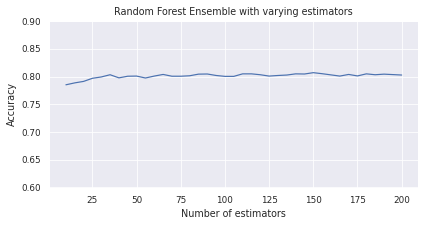

In [49]:
fig = plt.figure()
plt.plot(accuracies.keys(), accuracies.values())
plt.ylim(0.6, 0.9)
plt.title('Random Forest Ensemble with varying estimators')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.tight_layout()
fig.set_size_inches((6, 3))
# save
plt.savefig('rf_est.png', format='png')

best_est = max(accuracies, key=accuracies.get)
print(f'The model that performed the best was at {best_est} estimators, with an accuracy of {accuracies[best_est]}')

In [18]:
rf_model = RandomForestClassifier(n_estimators=best_est, criterion='gini')
rf_model.fit(words_train, y_train)

RandomForestClassifier(n_estimators=150)

## Naive Bayes Classifier

In [19]:
# encode three grams to work with CategoricalNB
encoder = OrdinalEncoder()
bayes_train = encoder.fit_transform(three_grams_train)

nb_model = CategoricalNB()
nb_model.fit(bayes_train, y_train)

CategoricalNB()

## CNN

In [20]:
# define custom callback class for tracking loss and accuracy while training
class authorship_callback(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accs = []
        self.precisions = []
        self.recalls = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('accuracy'))
        self.precisions.append(logs.get('precision_cnn'))
        self.recalls.append(logs.get('recall_cnn'))

# code reference for design of CNN: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
def define_model(input_len, output_size, vocab_size, embedding_dim, drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2):
    # channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # merge channels
    merged = concatenate([flat1, flat2, flat3])
    
    # create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # create model
    model = Model(inputs = [inputs1, inputs2, inputs3], outputs = output)
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(name='precision_cnn'), Recall(name='recall_cnn')])
    plot_model(model, show_shapes=True, to_file='cnn_arch.png')
    print(model.summary())
    return model

In [21]:
cnn_model = define_model(350, len(works), np.max(three_grams_train) + 1, 800)

2022-05-02 15:03:16.877311: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-02 15:03:16.877577: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 15:03:16.878987: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 350, 800)     20186400    input_1[0][0]                    
______________________________________________________________________________________________

In [22]:
training_history = authorship_callback()
cnn_model.fit(
    [three_grams_train, three_grams_train, three_grams_train], 
    author_one_hot_train, 
    batch_size=32,
    epochs=5, 
    verbose=1,
    validation_split=0.2,
    callbacks=[training_history]
)

Epoch 1/5


2022-05-02 15:03:17.221643: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-02 15:03:17.222064: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4200005000 Hz


282/282 [==============================] - 336s 1s/step - loss: 0.9293 - accuracy: 0.6006 - precision_cnn: 0.6711 - recall_cnn: 0.4649 - val_loss: 0.4078 - val_accuracy: 0.8289 - val_precision_cnn: 0.8595 - val_recall_cnn: 0.8022
Epoch 2/5
282/282 [==============================] - 333s 1s/step - loss: 0.1943 - accuracy: 0.9251 - precision_cnn: 0.9358 - recall_cnn: 0.9157 - val_loss: 0.5021 - val_accuracy: 0.8373 - val_precision_cnn: 0.8490 - val_recall_cnn: 0.8244
Epoch 3/5
282/282 [==============================] - 333s 1s/step - loss: 0.0476 - accuracy: 0.9826 - precision_cnn: 0.9859 - recall_cnn: 0.9798 - val_loss: 0.6735 - val_accuracy: 0.8444 - val_precision_cnn: 0.8488 - val_recall_cnn: 0.8382
Epoch 4/5
282/282 [==============================] - 343s 1s/step - loss: 0.0691 - accuracy: 0.9835 - precision_cnn: 0.9838 - recall_cnn: 0.9828 - val_loss: 1.2323 - val_accuracy: 0.8356 - val_precision_cnn: 0.8363 - val_recall_cnn: 0.8333
Epoch 5/5
282/282 [==============================]

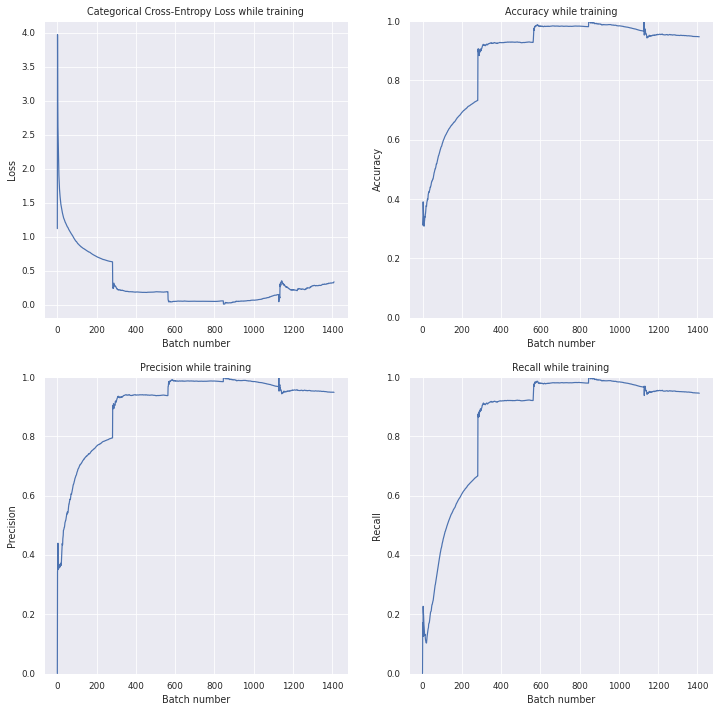

In [50]:
# get history parameters
cnn_loss = training_history.losses
cnn_acc = training_history.accs
cnn_pre = training_history.precisions
cnn_rec = training_history.recalls

# plot metrics gained while training
fig, axs = plt.subplots(2, 2)

# loss
axs[0, 0].plot(cnn_loss)
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Categorical Cross-Entropy Loss while training')

# accuracy
axs[0, 1].plot(cnn_acc)
axs[0, 1].set(ylabel='Accuracy')
axs[0, 1].set_title('Accuracy while training')

# precision
axs[1, 0].plot(cnn_pre)
axs[1, 0].set(ylabel='Precision')
axs[1, 0].set_title('Precision while training')

# recall
axs[1, 1].plot(cnn_rec)
axs[1, 1].set(ylabel='Recall')
axs[1, 1].set_title('Recall while training')

for i, ax in enumerate(axs.flat):
    ax.set(xlabel='Batch number')
    if i != 0:
        ax.set_ylim(0, 1)

fig.set_size_inches((12, 12))
# save
plt.savefig('cnn_training.png', format='png')

# Evaluation

In [29]:
cmap = sns.color_palette("Blues", as_cmap=True)

def plot_confusion_matrix(cm, classes, title, normalize=True):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap=cmap)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)

def print_scores(true, pred):
    print(classification_report(true, pred, target_names=works.keys()))

## SVM

              precision    recall  f1-score   support

      austen       0.82      0.83      0.83      1265
  chesterton       0.75      0.84      0.79      1208
 shakespeare       0.95      0.83      0.88      1277

    accuracy                           0.83      3750
   macro avg       0.84      0.83      0.83      3750
weighted avg       0.84      0.83      0.84      3750



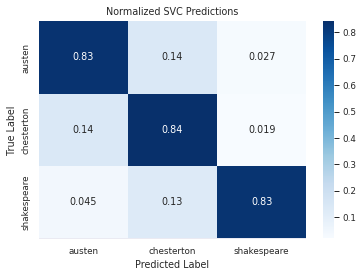

In [51]:
predictions = svc_model.predict(words_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes=works.keys(), title='Normalized SVC Predictions')
print_scores(y_test, predictions)
# save
plt.savefig('svc_cm.png', format='png')

## Random Forest Ensemble

              precision    recall  f1-score   support

      austen       0.80      0.76      0.78      1265
  chesterton       0.75      0.76      0.76      1208
 shakespeare       0.84      0.88      0.86      1277

    accuracy                           0.80      3750
   macro avg       0.80      0.80      0.80      3750
weighted avg       0.80      0.80      0.80      3750



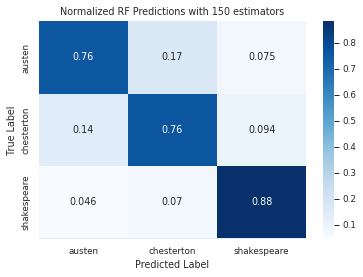

In [52]:
predictions = rf_model.predict(words_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes=works.keys(), title=f'Normalized RF Predictions with {best_est} estimators')
print_scores(y_test, predictions)
# save
plt.savefig('rf_cm.png', format='png')

## Naive Bayes

              precision    recall  f1-score   support

      austen       0.55      0.21      0.30      1265
  chesterton       0.41      0.40      0.41      1208
 shakespeare       0.44      0.73      0.55      1277

    accuracy                           0.45      3750
   macro avg       0.47      0.44      0.42      3750
weighted avg       0.47      0.45      0.42      3750



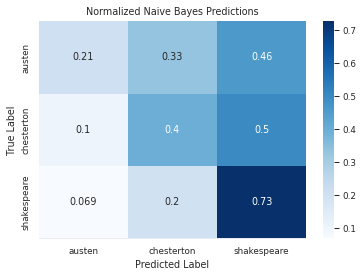

In [53]:
bayes_test = encoder.fit_transform(three_grams_test)
predictions = nb_model.predict(bayes_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes=works.keys(), title=f'Normalized Naive Bayes Predictions')
print_scores(y_test, predictions)
# save
plt.savefig('nb_cm.png', format='png')

## CNN

              precision    recall  f1-score   support

      austen       0.33      0.12      0.18      1265
  chesterton       0.32      0.50      0.39      1208
 shakespeare       0.37      0.40      0.38      1277

    accuracy                           0.34      3750
   macro avg       0.34      0.34      0.32      3750
weighted avg       0.34      0.34      0.32      3750



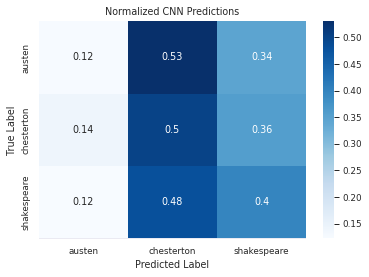

In [54]:
predictions = cnn_model.predict([three_grams_test, three_grams_test, three_grams_test])
predictions = list(lb.inverse_transform(predictions))
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes=works.keys(), title=f'Normalized CNN Predictions')
print_scores(y_test, predictions)
# save
plt.savefig('cnn_cm.png', format='png')